In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [43]:
words = open("names.txt", "r").read().splitlines()
#String to integer and integer to string mappings have been created
chars = sorted(list(set( "".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [44]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# How to optimally initialize the Model

### Expected loss
The initial loss of the function is over 27,8 which is all fucked up... Why? Let's assume a uniform distribution of 27 characters and calculate the loss: log(1/27) = 3,29
The problem is we initialize our values randomly from a normal distribution

Solution: Set bias to 0 and scale the Weights by a small number (0.01) to have values close to zero but not 0 to avoid 

### tanh
<img src ="tanh1.png" width = "300"> </br>
Our tanh puts most values to 1 or -1 and this reduces our learning rate. 
Backward pass of tanh look like (1-t^2) * out.grad -> If t is close to one our gradient is getting washed away, which makes our training very ineffective and it might even cause **braindamage** where a neuron is never activated for any example and it never learns

Solution: Scale down the Weights of the activation layer so that smaller numbers get passed to tanh, but with what?

### Kaiming initalisation
There is the so called Kaiming init, which states that we need to set our std deviation (i.e. multiply a gaussian with std = 1 by x) to </br></br> 
 <img src = "Gain.png" width= "300"/> 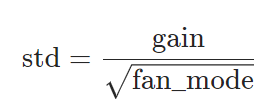 </br>
Where gain is a constant for every non linearity and fan_mode can be either fan_in(number of inputs to a layer) or fan_out(number of outputs of a layer) </br></br>

### Batch normalization

hpreact are the preactivations to our hidden layer which then are tanh'ed. We have seen that the input values that are around the gaussian distribution with std = 1 work best as we don't loose to much information, so then our idea is to **normalize** our batch. As you know from data science we can do this by calculating (x-mean)/std for every x. We also add 2 vectors bngain and bnbias to not enforce gaussian distribution outside of the initialisation. During training we also backpropagate through the bngain and bnbias to be able to distort the distribution.

Intrestingly it is common to add multiple bacth normalisation layers especially after linear layers like hpreact inside our Deep Neural network


BUT THERE IS A BAD THING, previusoly i didnt matter what examples were trained together in a batch, now they are mathematically connected, because we calculate their mean and std deviation, so we are like ooohh shiiiiiit! BUT, this actually creates a slight noise in our logits, which makes it harder for the network to overfit our examples. Therefore Batch Noramlisation has this additional regulatory property. 

Additional problem is that now when we want to sample from our model, then it expects a batch it can calculate a mean and std deviation on. Our solution is to calculate this 2 values during training and then use them as constants when sampling.

In Praxis batch normalization can cause a lot of bugs and headaches and should be used sparsley!

```python
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3) / (n_embd * block_size)**0.5 #Kaiming initialisation
#b1 = torch.randn(n_hidden, generator=g) * 0.01 #Not needed anymore, look in the training code
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden)) #On intialisation these parameters will be 1 so that we keep hpreact with the standard distribution, but then during backprob, we will be able to adjust these vectors, so that we can make some inputs more or less trigger happy etc
bnbias = torch.zeros((1, n_hidden)) # This is the same as above but here are zeros, remember Wx + b

#Calcuklating the mean and std dev of the entire training set during training
bnmean_running = torch.zeros((1, n_hidden)) # Mean of normal distribution will be intially around 1
bnstd_running = torch.ones((1, n_hidden))# std dev of normal distribution will be intially arounf 0 


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True
```

### Pytorching the code

Let us now create methods in our code for reusability of the layers, based on the Pytorch documentation </br>
- [Linearity](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [Batchnorm1D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
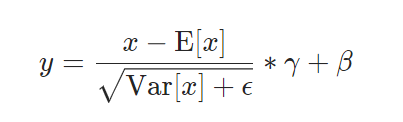
- [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)



In [45]:
class Linear:

    def __init__ (self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #Kaiming initialisation
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps # small number to avoid division by zero
        self.momentum = momentum
        self.training = True  #<- diffrent behaviour based on whether we are training or evaluating/sampling
        #parameters trained during backprop
        self.gamma = torch.ones(dim) #Weights for the normalisation of the input, previously we had bngain
        self.beta = torch.zeros(dim) #Bias for the normalisation of the input, previously we had bnbias
        #buffer computed parallel to backprop
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean 
            xvar = x.var(0, keepdim = True , unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # scale and shift
        #update the running mean and variance / buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta] # return the parameters that need to be trained, runnning mean and variance are not trained, they are updated during the forward pass
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility


C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size  , n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1  # value of gamma for normalization of the layers
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

######################




46497


In [46]:

max_steps = 200000

batch_size = 32

lossi = []

ud = [] # updtae to data ratio

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # We take a log of std of the update divided by std of the input data

    if i >= 1000:
        break #AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


Below we visualize how saturated our tanh is -> If t.abs() > 0.97 then our gradient gets washed away as we have seen previusoly. Our goal is to control the saturation

layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

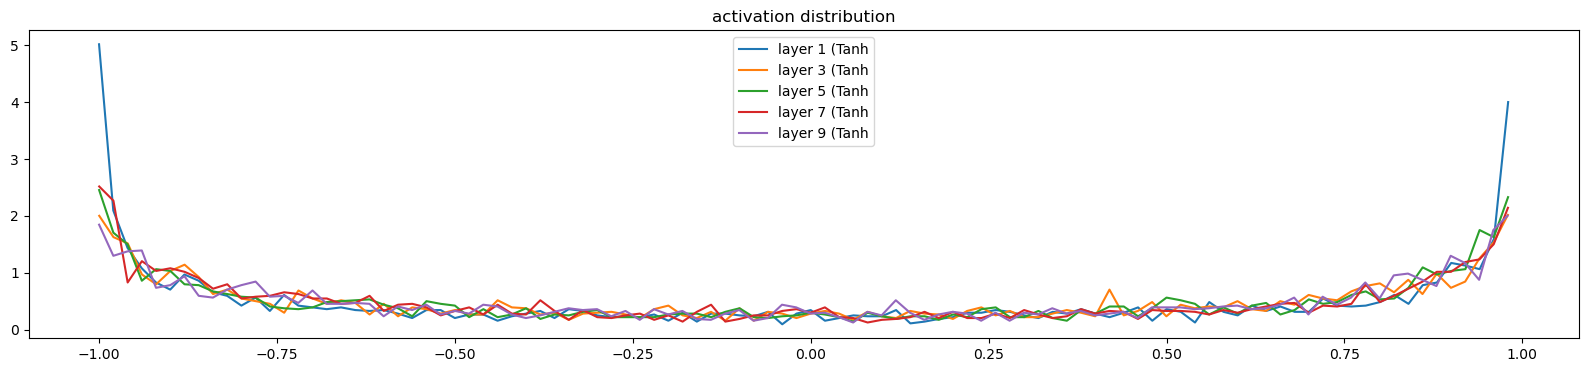

In [47]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Here we visualize the gradient in backpropagation. We want to ensure that our gradient is roughly the same for every layer, without being squashed or exploding. We control it with the value layer.weight.
Note: We dont use batch normalization here



layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

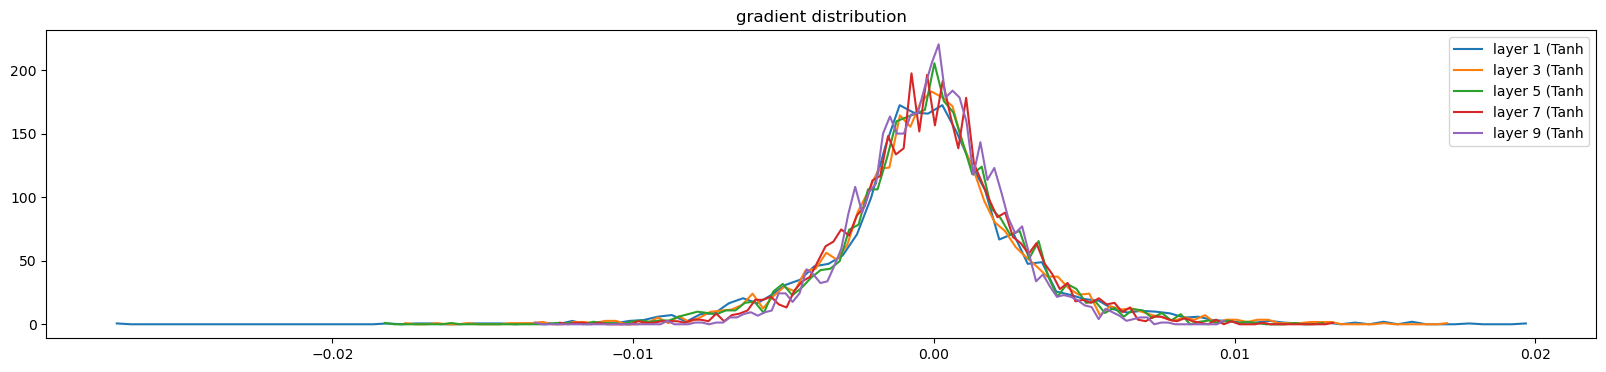

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189170e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214556e-02
weight (100, 100) | mean +0.000033 | std 7.821213e-03 | grad:data ratio 4.653363e-02
weight (100, 100) | mean -0.000107 | std 6.655619e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086039e-03 | grad:data ratio 3.605767e-02
weight (100, 100) | mean -0.000077 | std 5.075619e-03 | grad:data ratio 3.015268e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


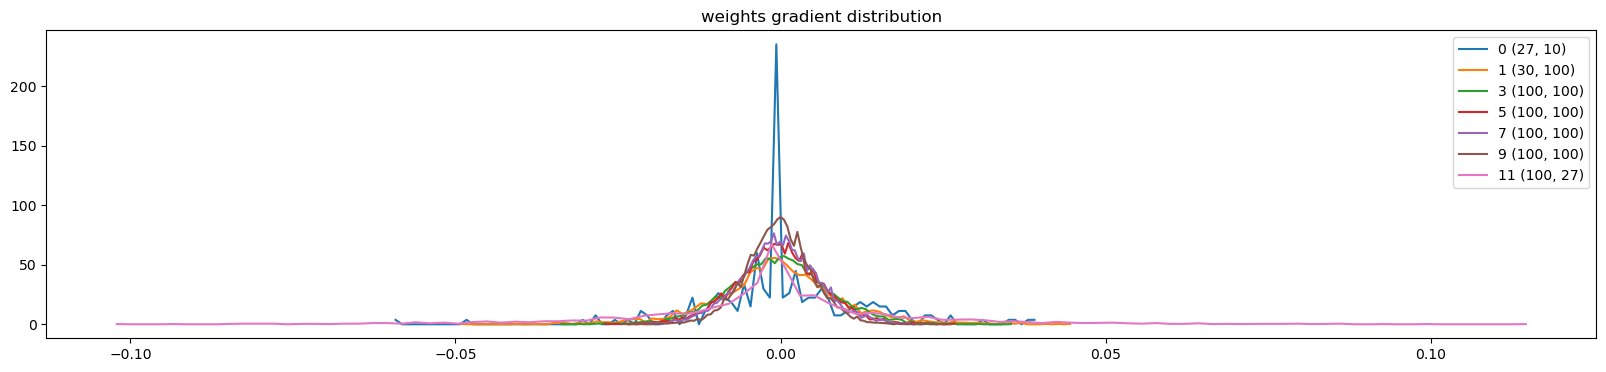

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

### Update to data ratio

Here we plot the update to data ratio over time. Ideally the value should be around (the average blakc line) 1e-3 -> -3.0 on log10 scale

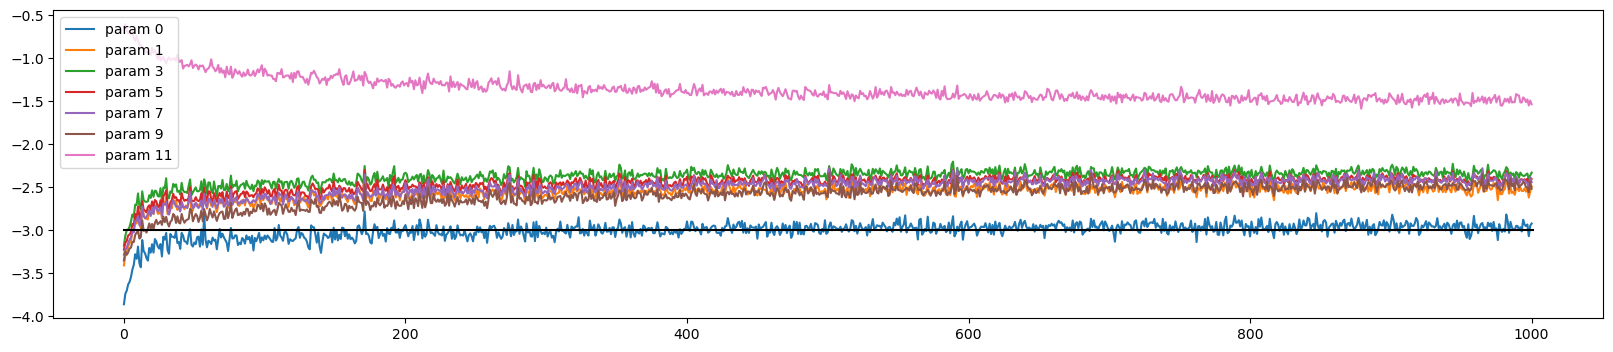

In [50]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# Evaluating the model


In [51]:
@torch.no_grad() # this decorator disables gradient tracking for efficiency, as we will not run any gradient optimzation on our evaluation
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # +b1 not needed
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # Batch normalisation layer
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


NameError: name 'W1' is not defined

# Sampling the Model


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1) #b1 not needed anymore 
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word


marvik.
sammi.
brand.
fran.
bravrngeld.
leg.
vished.
dlin.
shi.
jenu.
kenson.
passtelyz.
vivari.
nyshdbrrgianan.
styn.
josellenngtoriffuylka.
darujuclenekshlvy.
masklynn.
hal.
sakyansh.
